In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0.5, 0, 'number of diffusion steps')

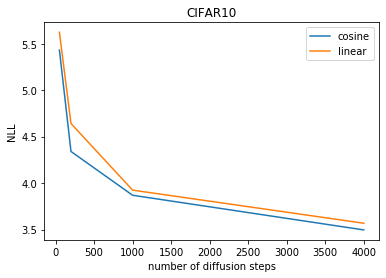

In [3]:
steps = [50, 200, 1000, 4000]
cosine_nll = [5.431,4.34,3.869, 3.496] 
linear_nll = [5.623,4.641,3.924,3.568]

plt.plot(steps[:len(cosine_nll)], cosine_nll, label='cosine')
plt.plot(steps, linear_nll, label='linear')
plt.legend()
plt.title("CIFAR10")
plt.ylabel('NLL')
plt.xlabel("number of diffusion steps")

Text(0.5, 0, 'number of diffusion steps')

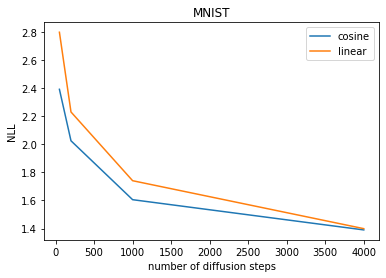

In [4]:
steps = [50, 200, 1000, 4000]
cosine_nll = [2.39, 2.024, 1.605, 1.39] 
linear_nll = [2.796, 2.229, 1.74, 1.399]

plt.plot(steps[:len(cosine_nll)], cosine_nll, label='cosine')
plt.plot(steps[:len(linear_nll)], linear_nll, label='linear')
plt.legend()
plt.title("MNIST")
plt.ylabel('NLL')
plt.xlabel("number of diffusion steps")

In [11]:
import torch 
import math
th=torch

def get_linear_alphas_bar(diffusion_steps):
    betas = get_betas(None, None, diffusion_steps, 'linear')
    alphas = 1 - betas
    alphas_sqrt = th.sqrt(alphas)
    return torch.cumprod(alphas, 0)

def cosine_alpha_bar(t):
    return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

def betas_for_alpha_bar(alpha_bar, diffusion_steps, max_beta):
    betas = []
    for i in range(diffusion_steps):
        t1 = i / diffusion_steps
        t2 = (i + 1) / diffusion_steps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return betas
    
def mixed_alpha_bar(diffusion_steps):
    lin_alphas = get_linear_alphas_bar(diffusion_steps)
    last_alpha = 2 * lin_alphas[-1] - lin_alphas[-2]
    lin_alphas = torch.cat([lin_alphas, torch.tensor([1]) * last_alpha])
    cos_alphas = torch.tensor([cosine_alpha_bar(t/diffusion_steps) for t in range(diffusion_steps+1)])
    mixed_alphas = 0.5 * lin_alphas + 0.5 * cos_alphas
    return mixed_alphas

def get_betas(
        beta_start=None, beta_end=None, diffusion_steps=1000, mode="linear", max_beta=0.999, custom_alpha_bar=None
):
    if mode == "linear":
        if beta_start is None or beta_end is None:
            # scale to the number of steps
            scale = 1000 / diffusion_steps
            beta_start = scale * 0.0001
            beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, diffusion_steps)
    elif mode == "cosine":
        betas = betas_for_alpha_bar(cosine_alpha_bar, diffusion_steps, max_beta)
        return torch.tensor(betas)
    elif mode == "mixed":
        alpha_bar = mixed_alpha_bar(diffusion_steps)
        betas = betas_for_alpha_bar(lambda t: alpha_bar[int(t*diffusion_steps)], diffusion_steps, max_beta)
        return torch.tensor(betas)
        return torch.tensor(betas)
    elif mode == "custom":
        betas = betas_for_alpha_bar(custom_alpha_bar, diffusion_steps, max_beta)
        return torch.tensor(betas)
    else:
        raise ValueError(f"Wrong beta mode: {mode}")

In [34]:
def get_all_vars(beta_start, beta_end, diffusion_steps, mode, max_beta=0.999):
    betas = get_betas(beta_start, beta_end, diffusion_steps, mode, max_beta)
    alphas = 1 - betas
    alphas_sqrt = th.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, 0)
    alphas_hat_sqrt = torch.sqrt(alphas_hat)
    one_min_alphas_hat_sqrt = torch.sqrt(1 - alphas_hat)
    alphas_hat_prev = torch.Tensor(np.append(1.0, alphas_hat[:-1].numpy()))
    alphas_hat_next = torch.Tensor(np.append(alphas_hat[1:].numpy(), 0.0))
    posterior_variance = (
            betas * (1.0 - alphas_hat_prev) / (1.0 - alphas_hat)
    )
    sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_hat)
    sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_hat - 1)

    posterior_mean_coef1 = (
            betas * torch.sqrt(alphas_hat_prev) / (1.0 - alphas_hat)
    )
    posterior_mean_coef2 = (
            (1.0 - alphas_hat_prev)
            * alphas_sqrt
            / (1.0 - alphas_hat)
    )

    denoising_coef = (betas / one_min_alphas_hat_sqrt)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_sqrt": alphas_sqrt,
        "alphas_hat": alphas_hat,
        "alphas_hat_sqrt": alphas_hat_sqrt,
        "one_min_alphas_hat_sqrt": one_min_alphas_hat_sqrt,
        "alphas_hat_prev": alphas_hat_prev,
        "alphas_hat_next": alphas_hat_next,
        "posterior_variance": posterior_variance,
        "sqrt_recip_alphas_cumprod": sqrt_recip_alphas_cumprod,
        "sqrt_recipm1_alphas_cumprod": sqrt_recipm1_alphas_cumprod,
        "posterior_mean_coef1": posterior_mean_coef1,
        "posterior_mean_coef2": posterior_mean_coef2,
        "denoising_coef": denoising_coef,
    }

def plot_keys(var_dicts, keys, labels):
#     colors = "rgbcmyk"
#     lines = ['-', '--', '-.', ':']
    colors = "kbrg"
    lines = ['-', '--', ':', '-.']
    
    for i, v in enumerate(var_dicts):
        lab = labels[i]
        l = lines[i]
        for j, k in enumerate(keys):
            c = colors[i]
#             plt.plot(v[k], c+l, label=lab + " " + k)
            plt.plot(v[k], c+l, label=lab)
    plt.legend()

In [35]:
diffusion_steps=1000
beta_start=None
beta_end=None
mode="linear"
vars_linear = get_all_vars(beta_start, beta_end, diffusion_steps, mode="linear")
vars_cosine = get_all_vars(beta_start, beta_end, diffusion_steps, mode="cosine")
vars_cosine_cap = get_all_vars(beta_start, beta_end, diffusion_steps, mode="cosine", max_beta=0.2)
vars_mixed = get_all_vars(beta_start, beta_end, diffusion_steps, mode="mixed", max_beta=0.2)


Text(0, 0.5, 'alpha hat')

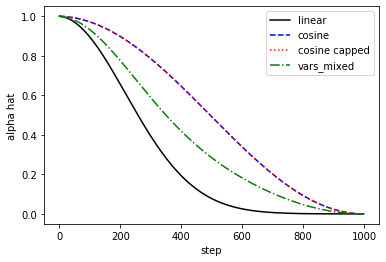

In [41]:
# plot_keys([vars_linear, vars_cosine, vars_cosine_cap], ['alphas_hat', 'denoising_coef'], ["linear", "cosine", "vars_cosine_cap"])
plot_keys([vars_linear, vars_cosine, vars_cosine_cap, vars_mixed], ['alphas_hat'], ["linear", "cosine","cosine capped", "vars_mixed"])
plt.xlabel('step')
plt.ylabel('alpha hat')
# plt.xlim((950,1000))
# plt.ylim((0.0,0.001))

Text(0, 0.5, 'beta')

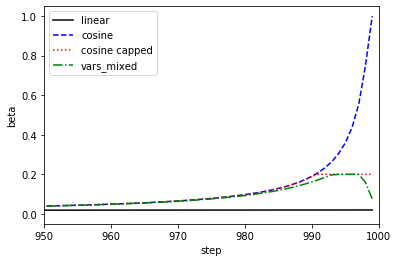

In [40]:
plot_keys([vars_linear, vars_cosine, vars_cosine_cap, vars_mixed], ['betas'], ["linear", "cosine","cosine capped", "vars_mixed"])
plt.xlim((950,1000))
plt.xlabel('step')
plt.ylabel('beta')
# plt.ylim((0.0,0.001))

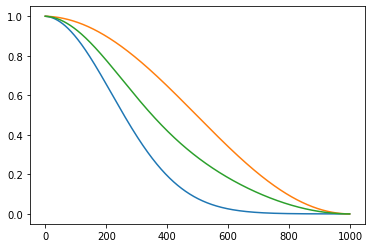

In [67]:
plt.plot(lin_alphas)
plt.plot(cos_alphas)
plt.plot(mixed_alphas)

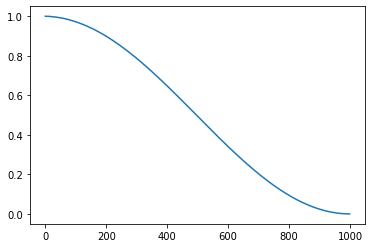

In [61]:
plt.plot([math.cos((t/1000 + 0.008) / 1.008 * math.pi / 2) ** 2 for t in range(1000)])